# Mean of a Gaussian process with icarogw

In this tutorial we are going to estimate the mean of a Gaussian process in presence of selection biases using icarogw. We are in the following situation

* A gaussian process with unkown mean $\mu_*=0$ and known variance $\sigma^2_*=1$ generates numbers $x$ with a rate $R_x$ of 100 samples per second. The samples rate per unit time can be written as 

$$\frac{dN}{dxdt}=R_x \mathcal{N}(x|\mu_*=0.,\sigma^2_*=1)$$

* Our detector does not directly register the $x$ values, but it instead it register a value $y$ contaminated by the noise. The likelihood of obtaining $y$ given $x$ is given by a random gaussian process.

$$\mathcal{L}_{\rm noise}(y|x)=\mathcal{N}(y|\mu=x,\sigma^2_n=1)$$

* Moreover, our detector is able only to register values of $y \in [-1,1]$

* Our task is to estimate the mean  $\mu_*$ of the original gaussian process with icarogw


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import icarogw
import shutil
import bilby

## Generation of mock data to use

Our first task is to generate mock data to use in our analysis. We need to do it consistently with the assumptions that we have made. We first need to generate the events from the gaussian process.

Text(0, 0.5, 'PDF')

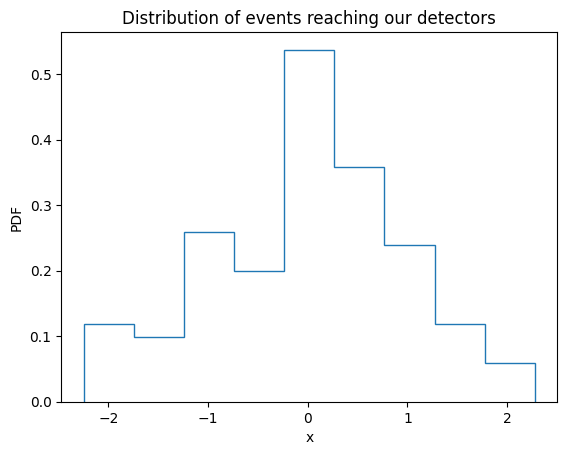

In [3]:
T_obs = 1 # Observation time in seconds
Rx = 100 # Rate of samples per second
x_true = np.random.randn(int(Rx*T_obs)) # Generate values of x according to the rate
plt.hist(x_true,bins='auto',density=True,histtype='step')
plt.title('Distribution of events reaching our detectors')
plt.xlabel('x')
plt.ylabel('PDF')

Next, we need to generate a noisy measure of $x$ according to the likelihood model $\mathcal{L}_{\rm noise}(y|x)$. Then on the generated value of $y$ we apply a selection cut. We assume that we can detect only the $y \in [-1,1]$.

You detected 40 events out of the 100 arrived


Text(0, 0.5, 'PDF')

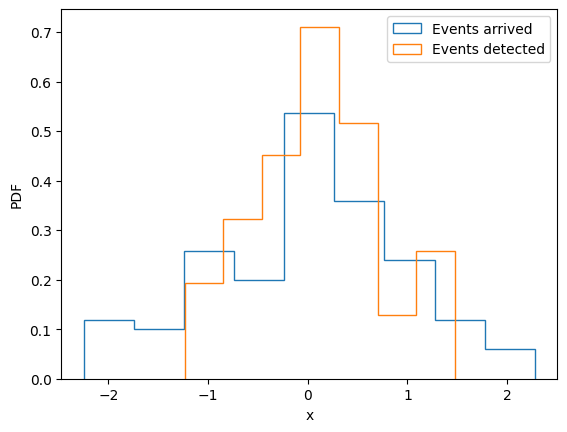

In [4]:
y_measured = x_true + np.random.randn(len(x_true)) # Generate a noisy measure
idx = (y_measured>-1) & (y_measured<1)
y_measured = y_measured[idx]
print('You detected {:d} events out of the {:d} arrived'.format(len(y_measured),len(x_true)))
plt.hist(x_true,bins='auto',density=True,histtype='step',label='Events arrived')
plt.hist(x_true[idx],bins='auto',density=True,histtype='step',label='Events detected')
plt.legend()
plt.xlabel('x')
plt.ylabel('PDF')

Now, the last step is to recgnise that we do not perfectly know $x$ for our events, instead we know $y$ and we are often provided with posterior samples on $x$. Namely, we are provided with samples of $x$ from the posterior

$$p(x|y)\propto \mathcal{L}_{\rm noise}(y|x)\pi(x)$$

if we generate posterior samples on $x$ using a flat prior, for this particular case it is trivial to see that the posterior samples of $x$ will be gaussian distributed around the value of $y$.

In [5]:
x_PE = []

for i in range(len(y_measured)):
    gsampler = bilby.core.prior.Normal(mu=y_measured[i],sigma=1.)
    x_PE.append(gsampler.sample(5000)) # Generate gaussian distribuited posterior samples

## The hierachical likelihood for the example

The hierarchical likelihood for the example above is given by

$$\mathcal{L}(\vec{y}|\mu_*) = e^{-N_{\rm exp}} \prod_{i}^{N_{\rm obs}} \int dx dt \mathcal{L}_{\rm noise}(y_i|x) \frac{dN}{dx dt} $$

where $\frac{dN}{dx dt}$ is the sample rate generation by the orginal gaussian process. We said that by hypothesis this is a gaussian process, so we can model 

$$\frac{dN}{dx dt}=R_x \mathcal{N}(x|\mu_*,\sigma^2)$$.

Plugging in the likelihood above we have

$$\mathcal{L}(\vec{y}|\mu_*) = e^{-N_{\rm exp}} \prod_{i}^{N_{\rm obs}} \int dx dt \mathcal{L}_{\rm noise}(y_i|x) R_x \mathcal{N}(x|\mu_*,\sigma^2) $$

$$\mathcal{L}(\vec{y}|\mu_*) = e^{-N_{\rm exp}} \prod_{i}^{N_{\rm obs}} T_{\rm obs} \int dx R_x \mathcal{L}_{\rm det}(y_i|x)  \mathcal{N}(x|\mu_*,\sigma^2) $$.

The expected number of detections $N_{\rm exp}$ can be calculated as

$$N_{\rm exp} = T_{\rm obs} \int dx p_{\rm det}(x) R_x \mathcal{N}(x|\mu_*,\sigma^2)$$.

### How we calculate the integral of the likelihood

We do it numerically, as we said we are provided with posterior samples on $x$ from the likelihood of the noise. Using the Bayes theorem we can write

$$\mathcal{L}(\vec{y}|\mu_*) = e^{-N_{\rm exp}} \prod_{i}^{N_{\rm obs}} T_{\rm obs} \int dx R_x \frac{p(x|y_i)}{\pi(x)}  \mathcal{N}(x|\mu_*,\sigma^2) $$

$$\mathcal{L}(\vec{y}|\mu_*) \approx e^{-N_{\rm exp}} \prod_{i}^{N_{\rm obs}}  \frac{T_{\rm obs}}{N_s}\sum_j^{N_s} R_x \frac{\mathcal{N}(x_j|\mu_*,\sigma^2)}{\pi(x_j)}   $$

### How we calculate $N_{\rm exp}$

This number is computed thanks to `injections`, the idea is basically to simulate $N_{\rm gen}$ sources, where $N_{\rm gen}$ is large and then record all the $N_{\rm det}$ injections that you are able to detect. Now, the injections are drawn from a prior $\pi_{\rm inj}(x)$, which is not the model for which we are trying to evaluate the selection bias, so we need to reweight them. We can calculate 

$$N_{\rm exp}=\frac{T_{\rm obs}}{N_{\rm gen}} \sum_j^{N_{\rm det}} R_x \frac{\mathcal{N}(x_j|\mu_*,\sigma^2)}{\pi(x_j)}$$

You detected 16577 events out of the 100000 arrived


Text(0, 0.5, 'PDF')

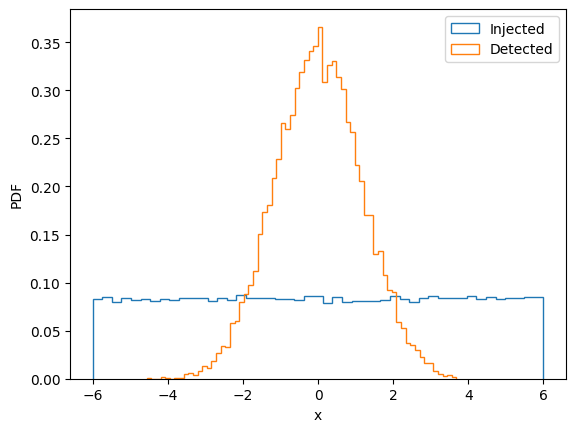

In [6]:
Ngen = 100000 # Ngen for the injections
x_injections = np.random.uniform(-6,6,Ngen) # Generates the x samples from a distributions which I think can cover all the detectable cases
y_measured = x_injections + np.random.randn(len(x_injections)) # Generate a measured value of y
idx = (y_measured>-1) & (y_measured<1) # Check what we can detect
y_measured = y_measured[idx]
print('You detected {:d} events out of the {:d} arrived'.format(len(y_measured),len(x_injections)))
plt.hist(x_injections,bins='auto',density=True,histtype='step',label='Injected')
plt.hist(x_injections[idx],bins='auto',density=True,histtype='step',label='Detected')
plt.legend()
plt.xlabel('x')
plt.ylabel('PDF')


### What does icarogw want?

icarogw wants you to tell how to calculate the rate per time for your model, i.e. it wants a rate class object that tell how to calculate

$$w_i \equiv R_x\frac{\mathcal{N}(x_j|\mu_*,\sigma^2)}{\pi(x_j)}$$


In [7]:
import bilby

class my_gaussian_rate(object):
    '''
    A class for the rate of the gaussian example
    '''
    def __init__(self,scale_free=False):
        self.scale_free = scale_free # The class needs to have a scale_free flag
        if scale_free:
            self.population_parameters =  ['mu_star'] # Population parameters
        else:
            self.population_parameters =  ['mu_star','Rx'] # Population parameters if you want the scale-free version
        self.GW_parameters = ['x'] # Events parameters, in this case we just have x
        
    def update(self,**kwargs): # We need a method that updates the pop model
        self.gmod = bilby.core.prior.Normal(mu=kwargs['mu_star'],sigma=1.) # Save a gaussian       
        if not self.scale_free:
            self.Rx = kwargs['Rx'] # Save Rx
        
    def log_rate_PE(self,prior,**kwargs): # Tells us how to calculate the log of the rate for the PE
        # prior is the prior that you applied to generate PE, written in the variable x
        log_weights = self.gmod.ln_prob(kwargs['x'])-np.log(prior)
        if not self.scale_free:
            log_out = log_weights + np.log(self.Rx)
        else:
            log_out = log_weights
        return log_out
    
    def log_rate_injections(self,prior,**kwargs): # Tells us how to calculate the log of the rate for the injections
        # prior is the prior that you applied to generate injections, written in the variable x
        return self.log_rate_PE(prior,**kwargs)
    
myrate = my_gaussian_rate() # Initialize the rate model

In [8]:
# Icarogw wants that you store all the PE in a dict of posterior_samples classes

posterior_dict = {}
for i in range(len(x_PE)): # Loop on all the events you detect
    posterior_dict[str(i)] = icarogw.posterior_samples.posterior_samples({'x':x_PE[i]}, # You need to provide the PE in a dict, IMPORTANT field of the dict is
                                                                         # equal to the variable needed to evaluate the rate, i.e. x
                                                                         prior=np.ones(5000) # PE have been generated with uniform prior in x, so here 
                                                                         # I pass a constant. NOT IMPORTANT if not normalized
                                                                        )

In [9]:
# Icarogw wants the injections to evaluate the selection bias to be stored
injections = icarogw.injections.injections({'x':x_injections}, # Same logic as the posterior samples class
                                           prior=np.ones_like(x_injections)/12, # Prior used for the injections, IMPORTANT need to be correctly normalized
                                           ntotal=Ngen, # Number of generated injections
                                           Tobs=1.) # Observation time in units compatible with Rx)
injections.update_cut(idx) # We apply the cut on the detected injections from before
myrate.update(Rx=100.,mu_star=0.) # We update the rate model, note this is the true model
injections.update_weights(myrate) # We update the weights of the injections 
Nexp = injections.expected_number_detections() # We calculate the expected number of detections
                                           
print('Example, for the true model you would expect {:f} detections in 1 second'.format(Nexp))

Example, for the true model you would expect 51.759460 detections in 1 second


In [10]:
# We define the hierarchical likelihood. This is a classical Bilby likelihood
likelihood = icarogw.likelihood.hierarchical_likelihood(posterior_dict, #Posterior samples dict
                                                        injections, # Injections class
                                                        myrate, # Rate model
                                                        nparallel=100, # Number of PE to use per event
                                                        neffPE=10, # Number of effective PE for numerical stability
                                                       neffINJ=None # Number of effective injections
                                                       )
# Priors
prior = {'mu_star': bilby.core.prior.Uniform(-2,2),
        'Rx': bilby.core.prior.LogUniform(1e-1,1e3)}

# Run bilby
myres = bilby.run_sampler(likelihood,priors=prior,save=False)

15:39 bilby INFO    : Running for label 'label', output will be saved to 'outdir'


Using 100 samples from each 40 posteriors


15:39 bilby INFO    : Analysis priors:
15:39 bilby INFO    : mu_star=Uniform(minimum=-2, maximum=2, name=None, latex_label=None, unit=None, boundary=None)
15:39 bilby INFO    : Rx=LogUniform(minimum=0.1, maximum=1000.0, name=None, latex_label=None, unit=None, boundary=None)
15:39 bilby INFO    : Analysis likelihood class: <class 'icarogw.likelihood.hierarchical_likelihood'>
15:39 bilby INFO    : Analysis likelihood noise evidence: nan
15:39 bilby INFO    : Single likelihood evaluation took 4.044e-04 s
15:39 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 500, 'bound': 'multi', 'sample': 'rwalk', 'periodic': None, 'reflective': None, 'update_interval': None, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args': None, 'grad_kwargs': None, 'compute_jac': False, 'enlarge': None, 'bootstrap': None,

3372it [04:24,  7.32it/s, bound:71 nc:296 ncall:5.6e+05 eff:0.6% logz=75.97+/-0.08 dlogz:0.100>0.1]    

15:43 bilby INFO    : Written checkpoint file outdir/label_resume.pickle


3372it [04:27, 12.61it/s, bound:71 nc:  1 ncall:5.6e+05 eff:0.7% logz=76.07+/-0.08 dlogz:0.000>0.1]



15:43 bilby INFO    : Sampling time: 0:04:27.227684
15:43 bilby INFO    : Summary of results:
nsamples: 3872
ln_noise_evidence:    nan
ln_evidence: 76.067 +/-  0.105
ln_bayes_factor:    nan +/-  0.105



In [11]:
shutil.rmtree('outdir')

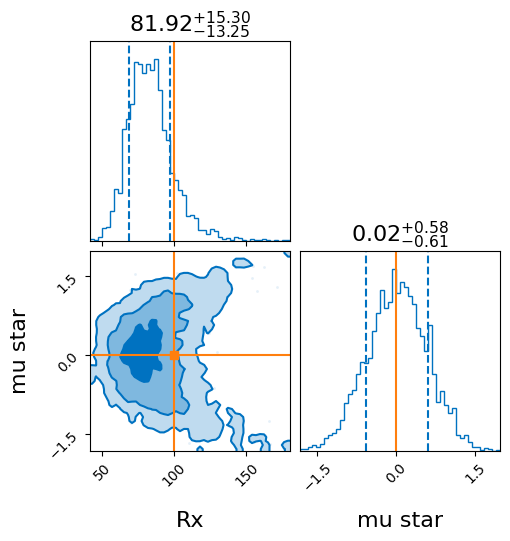

In [12]:
myres.plot_corner(truths={'Rx':100.,'mu_star':0.})